# Computing when two objects will be close form the Earth's POV

If we want to determine when two objects (the Moon and Venus in this case) are close together in the Earth's night sky we'll beed to compute the phase angle between the target objects as seen from Earth. 

In [1]:
import datetime
import spiceypy
import numpy as np
import pandas as pd

In [2]:
datapath = '/home/einhard/Documents/projects/'
spiceypy.furnsh(datapath + 'zData/spicepy/meta/_kernels.txt')

In [3]:
INIT_TIME_UTC_STR = datetime.datetime(year=2021, month=1, day=1).strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = datetime.datetime(year=2022, month=1, day=1).strftime('%Y-%m-%dT%H:%M:%S')

INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

# Setting number of seconds per hours. Used to compute phase angles in 1 hour steps
DELTA_HOUR_IN_SECONDS = 3600.0
TIME_INTERVAL_ET = np.arange(INIT_TIME_ET, END_TIME_ET, DELTA_HOUR_IN_SECONDS)

In [4]:
INNER_SOLSYS_DF = pd.DataFrame()

# Storing ETs
INNER_SOLSYS_DF['ET'] = TIME_INTERVAL_ET

# Transforming ET back to UTC
INNER_SOLSYS_DF['UTC'] = INNER_SOLSYS_DF['ET'].apply(lambda x: spiceypy.et2datetime(et=x))

# Computing phase angle between Venus and Sun as seen from Earth. We use the phaseq function; the "target" here is the Earth (or the position from which we want to see)
# The observer is the planet we are interested in - Venus, in this case

INNER_SOLSYS_DF['EARTH_VENUS2SUN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: np.degrees(spiceypy.phaseq(et=x,
                                                                     target='399',
                                                                     illmn='10',
                                                                     obsrvr='299',
                                                                     abcorr='LT+S')))

# Using the same function to compute the phase angle between Moon and Sun
INNER_SOLSYS_DF['EARTH_MOON2SUN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: np.degrees(spiceypy.phaseq(et=x,
                                                                     target='399',
                                                                     illmn='10',
                                                                     obsrvr='301',
                                                                     abcorr='LT+S')))

# Computing phase angle between Moon and Venus
INNER_SOLSYS_DF['EARTH_MOON2VEN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: np.degrees(spiceypy.phaseq(et=x,
                                                                     target='399',
                                                                     illmn='299',
                                                                     obsrvr='301',
                                                                     abcorr='LT+S')))

In [5]:
INNER_SOLSYS_DF

,ET,UTC,EARTH_VENUS2SUN_ANGLE,EARTH_MOON2SUN_ANGLE,EARTH_MOON2VEN_ANGLE
0,6.627313e+08,2021-01-01 00:00:00+00:00,20.369546,157.770044,137.489106
1,6.627349e+08,2021-01-01 00:59:59.999999+00:00,20.359775,157.269009,136.996356
2,6.627385e+08,2021-01-01 01:59:59.999998+00:00,20.350004,156.767557,136.503251
3,6.627421e+08,2021-01-01 02:59:59.999996+00:00,20.340233,156.265695,136.009791
4,6.627457e+08,2021-01-01 03:59:59.999995+00:00,20.330462,155.763426,135.515978
...,...,...,...,...,...
8755,6.942493e+08,2021-12-31 19:00:00.000014+00:00,13.378005,27.986732,41.214634
8756,6.942529e+08,2021-12-31 20:00:00.000012+00:00,13.319225,27.405551,40.578002
8757,6.942565e+08,2021-12-31 21:00:00.000011+00:00,13.260437,26.824229,39.941344
8758,6.942601e+08,2021-12-31 22:00:00.000010+00:00,13.201642,26.242790,39.304689


In [6]:
# Creating a binary column with 1 = good angles, 0 = bad angles
# Conditions: Sun-Venus theta > 30, Sun-Moon theta > 30, Moon-Venus theta < 10

INNER_SOLSYS_DF['PHOTOGENIC'] = \
    INNER_SOLSYS_DF.apply(lambda x: 1 if (x['EARTH_VENUS2SUN_ANGLE'] > 30.0) \
                                       & (x['EARTH_MOON2SUN_ANGLE'] > 30.0) \
                                       & (x['EARTH_MOON2VEN_ANGLE'] < 10.0) \
                                        else 0, axis=1)

In [7]:
print(f'Number of hours computed: {len(INNER_SOLSYS_DF)} (around {round(len(INNER_SOLSYS_DF) / 24)}) days')

print(f'Number of photogenic hours: {len(INNER_SOLSYS_DF[INNER_SOLSYS_DF["PHOTOGENIC"] == 1])}')

Number of hours computed: 8760 (around 365) days
Number of photogenic hours: 162


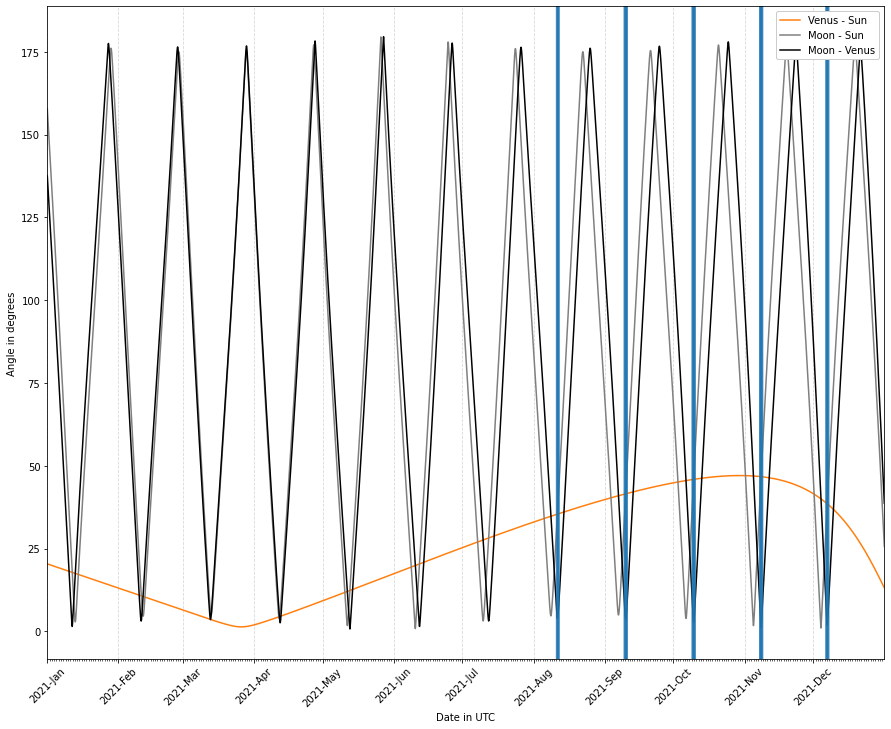

In [8]:
# Plotting photogenic days

from matplotlib import pyplot as plt
import matplotlib.dates as matpl_dates

fix, ax = plt.subplots(figsize=(15,12))

# Plotting miscellaneous phase angles
ax.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_VENUS2SUN_ANGLE'],
        color='tab:orange', label='Venus - Sun')

ax.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_MOON2SUN_ANGLE'],
        color='tab:gray', label='Moon - Sun')

ax.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_MOON2VEN_ANGLE'],
        color='black', label='Moon - Venus')

# Setting axis labels
ax.set_ylabel('Angle in degrees')
ax.set_xlabel('Date in UTC')

# Setting limits and grid
ax.set_xlim(min(INNER_SOLSYS_DF['UTC']), max(INNER_SOLSYS_DF['UTC']))
ax.grid(axis='x', linestyle='dashed', alpha=0.5)

# Setting month and day locator
ax.xaxis.set_major_locator(matpl_dates.MonthLocator())
ax.xaxis.set_minor_locator(matpl_dates.DayLocator())

# Setting fomat for datetime
ax.xaxis.set_major_formatter(matpl_dates.DateFormatter('%Y-%b'))
# Drawing vertical lines for photogenic conditions
for photogenic_utc in INNER_SOLSYS_DF[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]['UTC']:
    ax.axvline(photogenic_utc, color='tab:blue', alpha=0.2)

# Creating legend
ax.legend(fancybox=True, loc='upper right', framealpha=1)

# Rotating datetimes
plt.xticks(rotation=45)

plt.show()
# Saving fig
# plt.savefig('figures/VENUS_SUN_MOON.png', dpi=300)
